In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(".".join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}

In [3]:
# Build dataset

def build_dataset(n, data, splits):
  X, Y = [], []
  for w in data:
    padding = [0]*n
    for ch in w + '.':
      ix = stoi[ch]
      X.append(padding)
      Y.append(ix)
      padding = padding[1:] + [ix] #sliding window
  X,Y = torch.tensor(X),torch.tensor(Y)
  tr, va, te = splits
  tr = int(X.shape[0]*0.8)
  va = int(X.shape[0]*0.1)

  xtrain, ytrain = X[:tr], Y[:tr]
  xvalid, yvalid = X[tr:tr+va], Y[tr:tr+va]
  xtest, ytest = X[tr+va:], Y[tr+va:]
  return [xtrain, ytrain, xvalid, yvalid, xtest, ytest]

xtrain, ytrain, xvalid, yvalid, xtest, ytest = build_dataset(n=3, data=words, splits=(0.8, 0.1, 0.1))

In [46]:
g = torch.Generator().manual_seed(123123)

# Hyperparameters
n = 3 # trigram model
emb_sz = 10
n_hidden = 200
vocab_sz = len(chars) # it's 27

# --------------------------------------------------

# embedding matrix -> Hidden layer -> output layer
C  = torch.randn(vocab_sz, emb_sz,   generator=g)
w1 = torch.randn(n*emb_sz, n_hidden, generator=g) * (5/3) / ((n*emb_sz)**0.5)
# b1 = torch.randn(n_hidden,           generator=g) * 0.01
w2 = torch.randn(n_hidden, vocab_sz, generator=g) * 0.01
b2 = torch.randn(vocab_sz,           generator=g) * 0

hgain = torch.ones(1, n_hidden) # scale
hbias = torch.zeros(1, n_hidden) # offset
hmean_running = torch.zeros(1, n_hidden)
hstd_running = torch.ones(1, n_hidden)

# Setting up gradient requirements
parameters = [C, w1, w2, b2, hgain, hbias]
for p in parameters:
  p.requires_grad = True

sum([p.nelement() for p in parameters])

12297

In [47]:
lri = []
lossi = []
stepi = []

# Batch Normalization
The basic idea is as follow: we want out hidden state (h) to be in gaussian distribution, then why dont we take them and normalize them to be gaussian?

In [73]:
epoch = 200_000
bs = 32 # batch sz
wd = 0.01 # weight decay
epsilon = 0.01 # constant for batch norm

for i in range(epoch):
  # mini batch
  idx = torch.randint(0, xtrain.shape[0], size=(bs,))
  xbs, ybs = xtrain[idx], ytrain[idx] # batch

  # forward pass
  emb = C[xbs]
  hpreact = emb.view(emb.shape[0], -1) @ w1 # + b1
  hmean = hpreact.mean(0, keepdim=True)
  hstd = hpreact.std(0, keepdim=True)
  hpreact = hgain * (hpreact - hmean / hstd + epsilon) + hbias
  
  with torch.no_grad():
     hmean_running = 0.999 * hmean_running + hmean * 0.001
     hstd_running = 0.999 * hstd_running + hstd * 0.001

  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, ybs)
  perplexity = torch.exp(loss)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01 if i < 100_000 else 0.001
  for p in parameters:
      if p.grad is not None:  # Check if gradient is not None
          p.data -= p.grad.data * lr

  # track
  # lri.append(lr)
  # stepi.append(i)
  lossi.append(loss.log10().item())

  if i%10000 == 0:
    print(f"epoch: {i:7d}/{epoch:7d} | loss: {loss.item():.4f} | perplexity: {perplexity.item():.4f}")


epoch:       0/ 200000 | loss: 1.8563 | perplexity: 6.3997
epoch:   10000/ 200000 | loss: 2.1793 | perplexity: 8.8400
epoch:   20000/ 200000 | loss: 2.2164 | perplexity: 9.1744
epoch:   30000/ 200000 | loss: 2.0239 | perplexity: 7.5677
epoch:   40000/ 200000 | loss: 2.2295 | perplexity: 9.2956
epoch:   50000/ 200000 | loss: 2.3177 | perplexity: 10.1522
epoch:   60000/ 200000 | loss: 2.0368 | perplexity: 7.6661
epoch:   70000/ 200000 | loss: 1.8362 | perplexity: 6.2726
epoch:   80000/ 200000 | loss: 2.0736 | perplexity: 7.9532
epoch:   90000/ 200000 | loss: 1.8819 | perplexity: 6.5661
epoch:  100000/ 200000 | loss: 2.3132 | perplexity: 10.1069
epoch:  110000/ 200000 | loss: 1.6984 | perplexity: 5.4653
epoch:  120000/ 200000 | loss: 2.1778 | perplexity: 8.8266
epoch:  130000/ 200000 | loss: 1.8907 | perplexity: 6.6243
epoch:  140000/ 200000 | loss: 2.1736 | perplexity: 8.7897
epoch:  150000/ 200000 | loss: 2.0573 | perplexity: 7.8246
epoch:  160000/ 200000 | loss: 2.0905 | perplexity: 8.

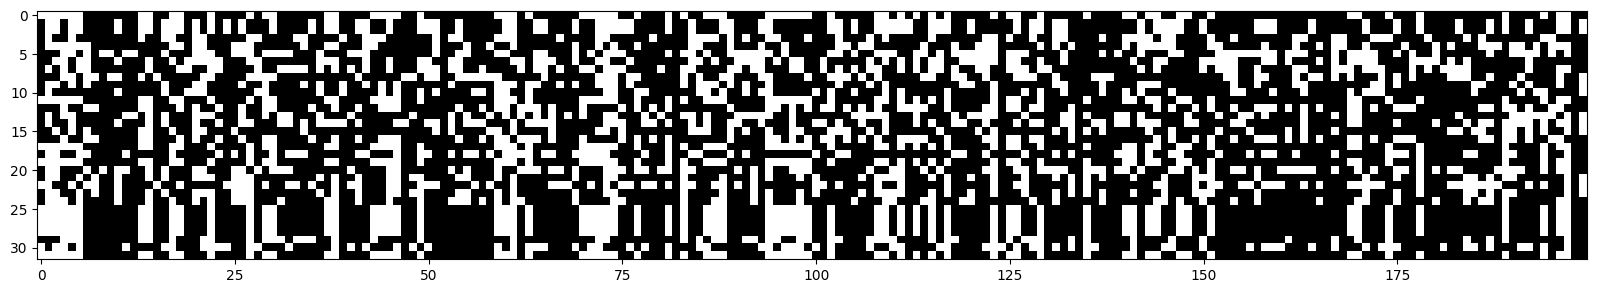

In [74]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [75]:
# instead of using z-score of test and valid batch, we use what we trained.
# this is not done, because this is an extra step b/w training and testing a model
# so instead we keep the track of std and mean while training, through running mean and std
with torch.no_grad():
  emb = C[xtrain]
  hpreact = emb.view(xtrain.shape[0], -1) @ w1 # + b1
  hgmean = hpreact.mean(0,keepdim=True)
  hbstd = hpreact.std(0,keepdim=True)

In [76]:
with torch.no_grad():
  # train loss
  emb = C[xtrain]
  hpreact = emb.view(emb.shape[0], -1) @ w1 # + b1
  hpreact = hgain * (hpreact - hgmean / hbstd) + hbias
  h = torch.tanh(hpreact)
  logits = h@w2 + b2
  tloss = F.cross_entropy(logits, ytrain)

  # valid loss
  emb = C[xvalid]
  hpreact = emb.view(emb.shape[0], -1) @ w1 # + b1
  hpreact = hgain * (hpreact - hgmean / hbstd) + hbias
  h = torch.tanh(hpreact)
  logits = h@w2 + b2
  vloss = F.cross_entropy(logits, yvalid)


print(f"train loss: {tloss.item():.4f}, valid loss: {vloss.item():.4f}")

train loss: 2.0424, valid loss: 2.3500


In [77]:
# using running std and mean of hidden state
with torch.no_grad():
  # train loss
  emb = C[xtrain]
  hpreact = emb.view(emb.shape[0], -1) @ w1 # + b1
  hpreact = hgain * (hpreact - hmean_running / hstd_running) + hbias
  h = torch.tanh(hpreact)
  logits = h@w2 + b2
  tloss = F.cross_entropy(logits, ytrain)

  # valid loss
  emb = C[xvalid]
  hpreact = emb.view(emb.shape[0], -1) @ w1 # + b1
  hpreact = hgain * (hpreact - hmean_running / hstd_running) + hbias
  h = torch.tanh(hpreact)
  logits = h@w2 + b2
  vloss = F.cross_entropy(logits, yvalid)


print(f"train loss: {tloss.item():.4f}, valid loss: {vloss.item():.4f}")

train loss: 2.0423, valid loss: 2.3502


In [165]:
#Sampling

for _ in range(10):
  padding = [0]*n
  out = []
  while True:
    idx = 0
    emb = C[torch.tensor([padding])]
    hpreact = emb.view(1,-1) @ w1
    hpreact = hgain * (hpreact - hmean_running / hstd_running) + hbias
    h = torch.tanh(hpreact)
    logits = torch.softmax(h@w2 + b2, 1)
    idx = torch.multinomial(logits, num_samples=1, replacement=True)
    padding = padding[1:] + [idx]
    out.append(itos[idx.item()])
    if idx == 0: break

  print("".join(out))

jocee.
tia.
ary.
luiumaimonie.
aalin.
peighnie.
anaison.
rudti.
funi.
rah.
